# VISION AND PERCEPTION PROJECT
**Continual Learning Applied on Colorectal Histology Image Data**

**Mert YILDIZ**

**1951070**

##Import All Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
from tqdm import tqdm
import time
import random
random.seed(42)
from tensorflow import keras
from keras.models import Sequential,Model
from keras.layers import Conv2D, MaxPooling2D, ReLU,  Flatten , Dense,Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from keras import backend as k
from keras.utils.vis_utils import plot_model
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

## Download Dataset

In [2]:
(training, validation, test), dataset_info = tfds.load('colorectal_histology',
    split=['train[:70%]', 'train[70%:85%]','train[85%:]'],
    with_info=True,
    as_supervised=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/colorectal_histology/2.0.0.incompleteHBRPOI/colorectal_histology-train.tfr…

Dataset colorectal_histology downloaded and prepared to /root/tensorflow_datasets/colorectal_histology/2.0.0. Subsequent calls will reuse this data.


## Exploratory Data Analysis

In [3]:
# Check amount of samples in each set
print('Number of Samples in ')
print()
print('Training Set:',len(training))
print('Validation Set:',len(validation))
print('Test Set:',len(test))

Number of Samples in 

Training Set: 3500
Validation Set: 750
Test Set: 750


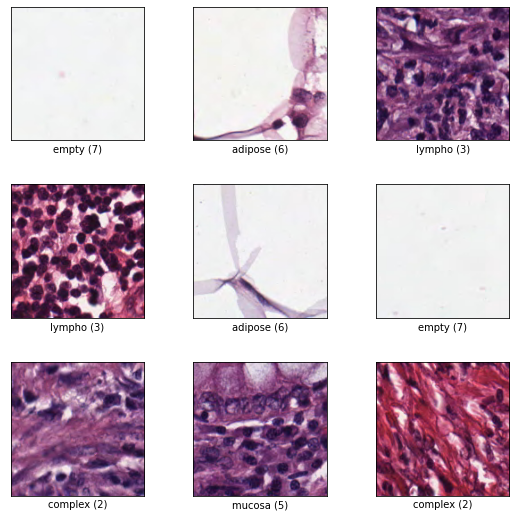

In [4]:
# Let's check some random sample from the test set
fig = tfds.show_examples(test, dataset_info)

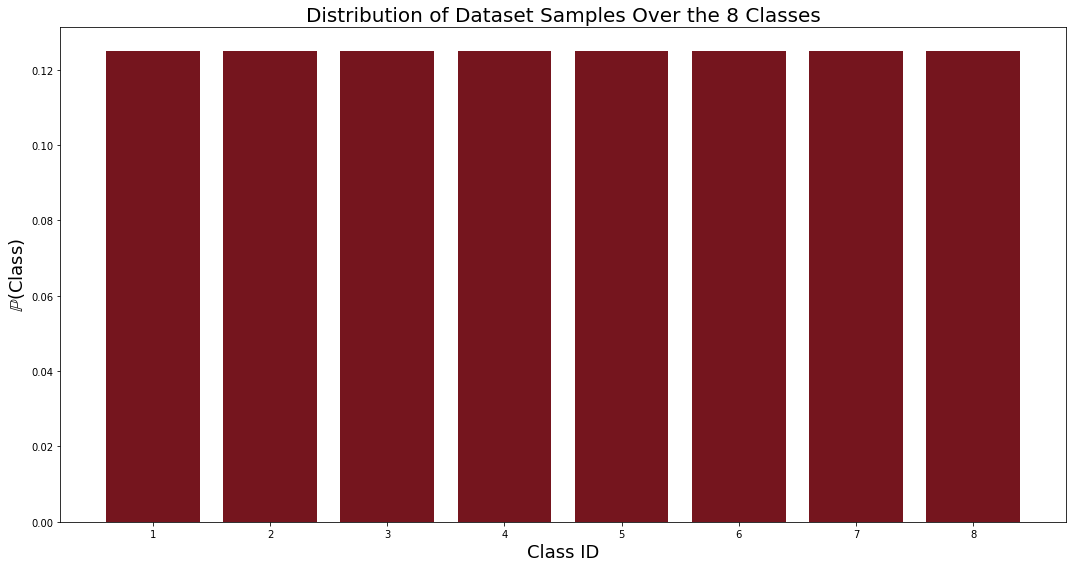

In [5]:
# Check the labels and append them to the list to check their distribution 

classes=np.zeros(8)

for item in training:
  classes[item[1].numpy()]+=1
for item in validation:
  classes[item[1].numpy()]+=1
for item in test:
  classes[item[1].numpy()]+=1
classes_distro=classes/np.sum(classes)

plt.figure(figsize=(15,8),tight_layout=True)
plt.style.use('seaborn-deep')
plt.title((r'Distribution of Dataset Samples Over the 8 Classes'),fontsize=20)
plt.xlabel((r'Class ID'),fontsize=18)
plt.ylabel((r'$\mathbb{P}$(Class)'),fontsize=18)
plt.bar(np.arange(1,9),classes_distro, label=r'$\alpha_s$',color='#75151e')
plt.show()

## Model

## Without Regularization

In [ ]:
# Define the CNN with the Sequential API
model = Sequential()

# 1st block
model.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(150, 150,3),activation="linear",padding='same'))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

# 2nd block
model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same'))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

# 3rd block
model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same'))
model.add(MaxPooling2D((6, 6),padding='valid'))
model.add(ReLU())

# Dense classifier
model.add(Flatten())
model.add(Dense(512, activation='linear'))
model.add(ReLU())
model.add(Dense(8, activation='softmax'))

# Number of epochs and batch size
BATCH_SIZE = 32
EPOCHS = 20

# Define the function to normalize pixel values in the range [0,1]
def pixel_normalizer(x,y):
  return x/255,y

train=training.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)
valid=validation.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)
tst=test.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)

# Initialize selected loss function and optimizer
cross_entropy = tf.losses.SparseCategoricalCrossentropy()
adam = tf.optimizers.Adam()

# Initialize chosen callback
mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

# Compile the model
model.compile(loss=cross_entropy, optimizer=adam,metrics=["accuracy"])

# Fit the model and train
conv_train=model.fit(
    train, 
    epochs=EPOCHS,
    validation_data=valid,
    callbacks=[mcp_save])


Epoch 1/20
110/110 [==============================] - 6s 51ms/step - loss: 1.2103 - accuracy: 0.5029 - val_loss: 0.7862 - val_accuracy: 0.7093
Epoch 2/20
110/110 [==============================] - 6s 51ms/step - loss: 0.8257 - accuracy: 0.6666 - val_loss: 0.7035 - val_accuracy: 0.7187
Epoch 3/20
110/110 [==============================] - 5s 49ms/step - loss: 0.6450 - accuracy: 0.7591 - val_loss: 0.6858 - val_accuracy: 0.7133
Epoch 4/20
110/110 [==============================] - 5s 50ms/step - loss: 0.5484 - accuracy: 0.7969 - val_loss: 0.5149 - val_accuracy: 0.8133
Epoch 5/20
110/110 [==============================] - 5s 49ms/step - loss: 0.5302 - accuracy: 0.8057 - val_loss: 0.5291 - val_accuracy: 0.8040
Epoch 6/20
110/110 [==============================] - 5s 49ms/step - loss: 0.4949 - accuracy: 0.8177 - val_loss: 0.5247 - val_accuracy: 0.7947
Epoch 7/20
110/110 [==============================] - 6s 50ms/step - loss: 0.4156 - accuracy: 0.8457 - val_loss: 0.4586 - val_accuracy: 0.8280

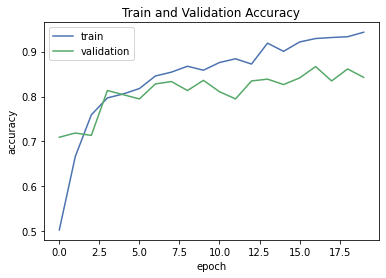

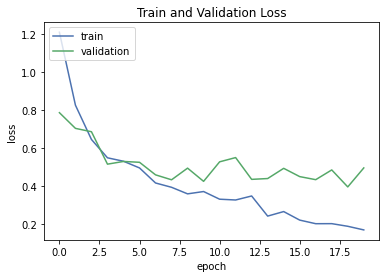

In [ ]:
# Plot loss and accuracy trends both on the training and validation set.
# "Accuracy"
plt.plot(conv_train.history['accuracy'])
plt.plot(conv_train.history['val_accuracy'])
plt.title('Train and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(conv_train.history['loss'])
plt.plot(conv_train.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
# Load best model
model.load_weights('best_model.hdf5')

# Evaluate model performances on top of the test set..
results = model.evaluate(tst)
print("\nTest loss: ",np.round(results[0],4),"\nTest accuracy: ", np.round(results[1],4))

24/24 [==============================] - 1s 21ms/step - loss: 0.3948 - accuracy: 0.8787

Test loss:  0.3948 
Test accuracy:  0.8787


F1 score by classes:  [0.9        0.72049689 0.8        0.93989071 0.83870968 0.91954023
 0.94972067 0.95522388]

Macro F1 Score:  0.8779477578856176



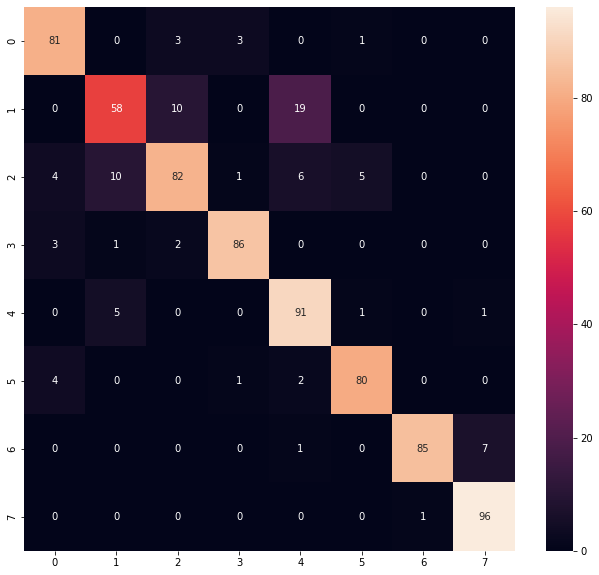

In [ ]:
# Calculate F1 Score and print Confusion Matrix
def F1_score_conf_matrix(model,tst):
    y_true = np.empty(0)
    predictions = np.empty(0)
    for x,y in tst:
        y_true = np.concatenate((y_true,y))
        y_pred = tf.argmax(model.predict(x,verbose = False),axis = 1)
        predictions = np.concatenate((predictions,y_pred))
    y_pred = predictions

    print('F1 score by classes: ',f1_score(y_true, y_pred,average=None))
    print()
    print('Macro F1 Score: ',f1_score(y_true, y_pred,average='macro'))
    print()
    cf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize = (11,10))
    sns.heatmap(cf_matrix, annot=True)
    plt.show()

F1_score_conf_matrix(model,tst)


## With Dropout as Regularization

In [ ]:
p = 0.3

EPOCHS = 30

train=training.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)
valid=validation.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)
tst=test.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)

model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(150,150,3),activation="linear",padding='same'))
model.add(Dropout(p))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same'))
model.add(Dropout(p))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same'))
model.add(Dropout(p))
model.add(MaxPooling2D((6, 6),padding='valid'))
model.add(ReLU())

model.add(Flatten())
model.add(Dense(512, activation='linear'))
model.add(Dropout(p))
model.add(ReLU())
model.add(Dense(8, activation='softmax'))

cross_entropy = tf.losses.SparseCategoricalCrossentropy()
adam = tf.optimizers.Adam()

earlyStopping = EarlyStopping(monitor='val_loss', patience=7, verbose=0, mode='min',restore_best_weights=True)
mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss=cross_entropy, optimizer=adam,metrics=["accuracy"])

# Fit the model and train
conv_train=model.fit(
    train, 
    epochs=EPOCHS,
    validation_data=valid,
    callbacks=[earlyStopping, mcp_save])

Epoch 1/30
110/110 [==============================] - 10s 82ms/step - loss: 1.3740 - accuracy: 0.4060 - val_loss: 1.3110 - val_accuracy: 0.3920
Epoch 2/30
110/110 [==============================] - 8s 76ms/step - loss: 0.8527 - accuracy: 0.6374 - val_loss: 1.1102 - val_accuracy: 0.7067
Epoch 3/30
110/110 [==============================] - 8s 76ms/step - loss: 0.6703 - accuracy: 0.7426 - val_loss: 0.8878 - val_accuracy: 0.7640
Epoch 4/30
110/110 [==============================] - 8s 76ms/step - loss: 0.6678 - accuracy: 0.7474 - val_loss: 0.8645 - val_accuracy: 0.8120
Epoch 5/30
110/110 [==============================] - 8s 76ms/step - loss: 0.5594 - accuracy: 0.7894 - val_loss: 0.8201 - val_accuracy: 0.8187
Epoch 6/30
110/110 [==============================] - 8s 76ms/step - loss: 0.5121 - accuracy: 0.8120 - val_loss: 0.8129 - val_accuracy: 0.7667
Epoch 7/30
110/110 [==============================] - 8s 75ms/step - loss: 0.5041 - accuracy: 0.8117 - val_loss: 0.9681 - val_accuracy: 0.606

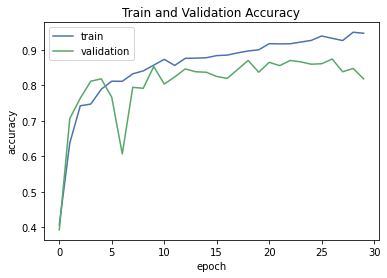

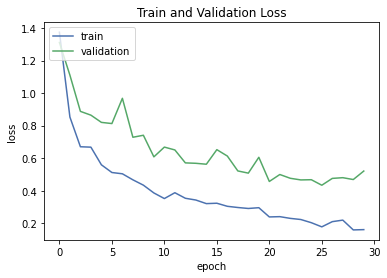

In [ ]:
# Plot loss and accuracy trends both on the training and validation set.
# "Accuracy"
plt.plot(conv_train.history['accuracy'])
plt.plot(conv_train.history['val_accuracy'])
plt.title('Train and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(conv_train.history['loss'])
plt.plot(conv_train.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
model.load_weights('best_model.hdf5')

results = model.evaluate(tst)
print("\nTest loss: ",np.round(results[0],4),"\nTest accuracy: ", np.round(results[1],4))

24/24 [==============================] - 1s 23ms/step - loss: 0.4071 - accuracy: 0.8840

Test loss:  0.4071 
Test accuracy:  0.884


F1 score by classes:  [0.91208791 0.74594595 0.80382775 0.93922652 0.84693878 0.94117647
 0.93478261 0.96373057]

Macro F1 Score:  0.8859645691636657



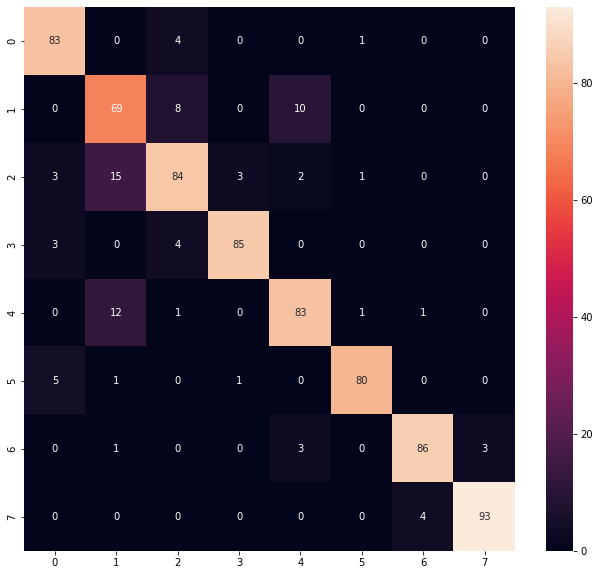

In [ ]:
F1_score_conf_matrix(model,tst)

## With L2 Regularization

In [9]:
# Optimize the L2 regularization parameters and train on best performing on test set later.
parameters = [0.05,0.01,0.005,0.001]
acc_results = []

EPOCHS = 20

for L2 in tqdm(parameters):  

    train=training.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)
    valid=validation.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)
    tst=test.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)

    model = Sequential()

    model.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(150,150,3),activation="linear",padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2)))
    model.add(MaxPooling2D((5, 5),padding='valid'))
    model.add(ReLU())

    model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2)))
    model.add(MaxPooling2D((5, 5),padding='valid'))
    model.add(ReLU())

    model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2)))
    model.add(MaxPooling2D((6, 6),padding='valid'))
    model.add(ReLU())

    model.add(Flatten())
    model.add(Dense(512, activation='linear',kernel_regularizer=tf.keras.regularizers.l2(L2)))
    model.add(ReLU())
    model.add(Dense(8, activation='softmax'))

    cross_entropy = tf.losses.SparseCategoricalCrossentropy()
    adam = tf.optimizers.Adam()

    mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

    model.compile(loss=cross_entropy, optimizer=adam,metrics=["accuracy"])

    # Fit the model and train
    conv_train=model.fit(
        train, 
        epochs=EPOCHS,
        validation_data=valid,
        callbacks=[mcp_save],
        verbose = False)
    
    model.load_weights('best_model.hdf5')

    results = model.evaluate(tst)
    acc_results.append(np.round(results[1],4))
    
acc_results

  0%|          | 0/5 [00:00<?, ?it/s]

24/24 [==============================] - 1s 22ms/step - loss: 2.0798 - accuracy: 0.1307


 20%|██        | 1/5 [02:30<10:01, 150.32s/it]

24/24 [==============================] - 1s 23ms/step - loss: 1.0193 - accuracy: 0.6973


 40%|████      | 2/5 [05:23<08:11, 163.72s/it]

24/24 [==============================] - 1s 23ms/step - loss: 0.7529 - accuracy: 0.8080


 60%|██████    | 3/5 [07:52<05:13, 156.96s/it]

24/24 [==============================] - 1s 22ms/step - loss: 0.6642 - accuracy: 0.8320


 80%|████████  | 4/5 [10:39<02:41, 161.06s/it]

24/24 [==============================] - 1s 22ms/step - loss: 0.5295 - accuracy: 0.8493


100%|██████████| 5/5 [13:08<00:00, 157.62s/it]


[0.1307, 0.6973, 0.808, 0.832, 0.8493]

In [10]:
L2 = 0.001

train=training.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)
valid=validation.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)
tst=test.shuffle(1000).batch(BATCH_SIZE).map(pixel_normalizer)

model = Sequential()

model.add(Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(150,150,3),activation="linear",padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2)))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2)))
model.add(MaxPooling2D((5, 5),padding='valid'))
model.add(ReLU())

model.add(Conv2D(512, (3, 3),strides=(1, 1), activation='linear',padding='same',kernel_regularizer=tf.keras.regularizers.l2(L2)))
model.add(MaxPooling2D((6, 6),padding='valid'))
model.add(ReLU())

model.add(Flatten())
model.add(Dense(512, activation='linear',kernel_regularizer=tf.keras.regularizers.l2(L2)))
model.add(ReLU())
model.add(Dense(8, activation='softmax'))

cross_entropy = tf.losses.SparseCategoricalCrossentropy()
adam = tf.optimizers.Adam()

mcp_save = ModelCheckpoint('best_model.hdf5', save_best_only=True, monitor='val_loss', mode='min')

model.compile(loss=cross_entropy, optimizer=adam,metrics=["accuracy"])

# Fit the model and train
conv_train=model.fit(
    train, 
    epochs=EPOCHS,
    validation_data=valid,
    callbacks=[mcp_save],
    verbose = False)

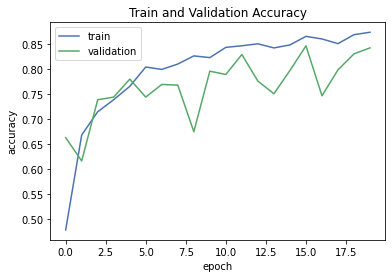

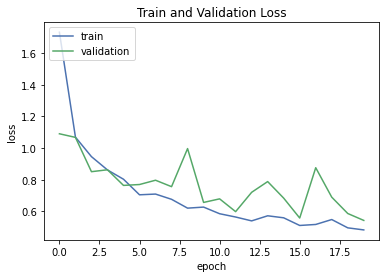

In [16]:
# Plot loss and accuracy trends both on the training and validation set.
# "Accuracy"
plt.plot(conv_train.history['accuracy'])
plt.plot(conv_train.history['val_accuracy'])
plt.title('Train and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(conv_train.history['loss'])
plt.plot(conv_train.history['val_loss'])
plt.title('Train and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [17]:
model.load_weights('best_model.hdf5')

results = model.evaluate(tst)
print("\nTest loss: ",np.round(results[0],4),"\nTest accuracy: ", np.round(results[1],4))

24/24 [==============================] - 1s 24ms/step - loss: 0.5101 - accuracy: 0.8573

Test loss:  0.5101 
Test accuracy:  0.8573


F1 score by classes:  [0.88648649 0.64285714 0.76923077 0.94565217 0.76616915 0.9132948
 0.96256684 0.96907216]

Macro F1 Score:  0.8569161917840498



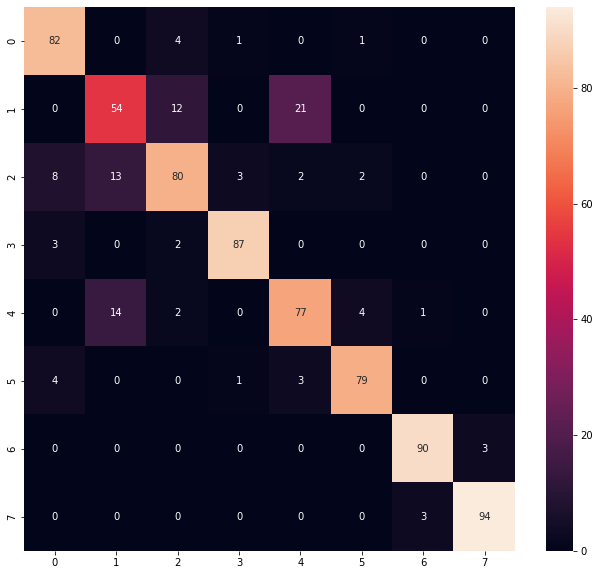

In [18]:
F1_score_conf_matrix(model,tst)

## Continual Learning

In [20]:
# As our labels are from {1 - 8} so when we are going to use sparsecategorical crossentropy, we need them to be {0,1} scale
def normalize_pixels_scale_labels(x,y,scale):
  return x/255,y-scale

# Split the dataset to 4 tasks
def splitting_tasks(dataset,num_tasks):
  return [dataset.filter(lambda text, label: label == i) for i in range(num_tasks)] 

num_classes=8
num_tasks = 4

train_data = splitting_tasks(training,num_classes)
valid_data = splitting_tasks(validation,num_classes)
test_data = splitting_tasks(test,num_classes)

In [21]:
# Define multi-head architecture
input = keras.Input(shape=(150, 150, 3), name="image")

# 1st Block
first = Conv2D(128, kernel_size=(3, 3),strides=(1, 1),input_shape=(64,64,3),activation="linear",padding='same',name="2DConv_1")(input)
first = MaxPooling2D((5, 5),padding='valid',name="2DMaxpool_1")(first)
first = ReLU(name="Relu_1")(first)

# 2nd Block
second = Conv2D(128, kernel_size=(3, 3),strides=(1, 1),activation="linear",padding='same',name="2DConv_2")(first)
second = MaxPooling2D((5, 5),padding='valid',name="2DMaxpool_2")(second)
second = ReLU(name="Relu_2")(second)

# 3rd Block
third = Conv2D(128, kernel_size=(3, 3),strides=(1, 1),activation="linear",padding='same',name="2DConv_3")(second)
third = MaxPooling2D((6, 6),padding='valid',name="2DMaxpool_3")(third)
third = ReLU(name="Relu_3")(third)

# Dense Classifier
flat = Flatten(name="Flatten")(third)
dense = Dense(128, activation='linear',name="Final_Dense")(flat)

# Multiple Heads
head_0=Dense(2, activation='softmax',name="head_0")(dense)
head_1=Dense(2, activation='softmax',name="head_1")(dense)
head_2=Dense(2, activation='softmax',name="head_2")(dense)
head_3=Dense(2, activation='softmax',name="head_3")(dense)

mul_head = keras.Model(inputs=input, outputs=[head_0,head_1,head_2,head_3], name="Multiple_Head_Model")

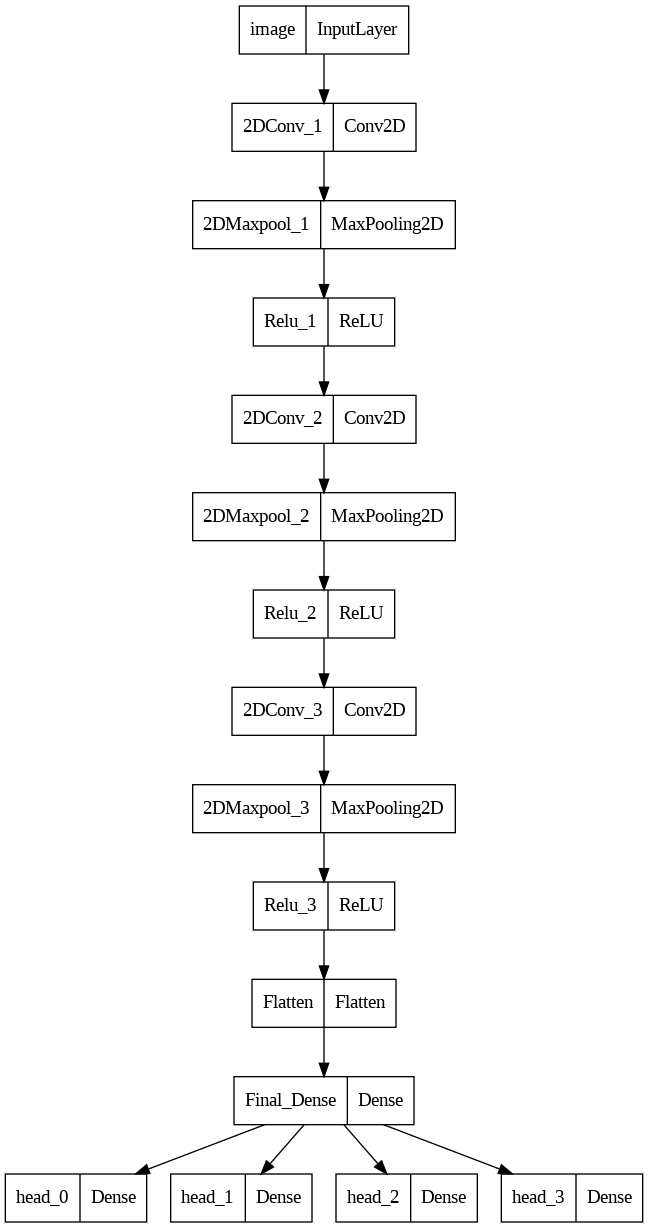

In [22]:
# Plot model
plot_model(mul_head)

**In here to calculate the fisher matrix as per the research I have done mostly the paper given below was pointed and I have just tried to change but it would still be the same since the calculation is the same but I have adapted to my case.**

https://seanmoriarity.com/2020/10/18/continual-learning-with-ewc/

In [23]:
# Define the function to compute Fisher matrix
def compute_fisher_matrix(model, task_set, batch_size,task_id):

  # Build fisher matrixes dictionary: at each key it will store the Fisher matrix for a particular layer
  fisher_matrixes = {n: tf.zeros_like(p.value()) for n, p in enumerate(model.trainable_variables)}
 
  for i, (imgs, labels) in enumerate(task_set.take(batch_size)):
    # Initialize gradients storage
    with tf.GradientTape() as tape:

      # Compute the predictions (recall: we will just take the prediction from the head related to the actual task)
      preds = model(imgs)[task_id]

      # Compute the logarithm of the predictions
      ll= tf.math.log(preds)

    # Attach gradients over the log_likelihood to log_likelihood_grads
    ll_grads  = tape.gradient(ll, model.trainable_variables)

    # Compute Fisher matrix at each layer (if existing)
    for i, gradients in enumerate(ll_grads):
      if gradients != None:
        fisher_matrixes[i] += tf.math.reduce_mean(gradients ** 2, axis=0) / batch_size
 
  return fisher_matrixes

# A wrapper has been used in the custom loss to send the old model parameters, the Fisher matrixes and the Lambda control value into the loss computation.
def EWC_loss(F,task_prev_param,Lambda): 

  def custom_loss(y_true, y_pred):
    # Compute standard cross entropy loss
    loss=tf.keras.losses.SparseCategoricalCrossentropy()
    normal_loss=loss(y_true,y_pred)

    # Compute EWC regularization term
    regularization_value=tf.constant([0.])
    for layer in range(len(F)):
      regularization_value+=tf.reduce_sum(F[layer]*(task_prev_param[layer]-mul_head.trainable_variables[layer])**2)

    # Return the standard cross entropy loss + EWC regularization
    return normal_loss+regularization_value*Lambda
  return custom_loss

# Define custom function to compute accuracy of the model for the test set
def check_test_acc(model,task,test_data,normalizer_scaler):
  counter=0
  correct=0
  scale=2*task

  for x,y in test_data[scale].concatenate(test_data[scale+1]).shuffle(1000).batch(1).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)):
    counter+=1
    if tf.math.argmax(model(x)[task],1).numpy()[0] == y.numpy()[0]:
      correct+=1

  return correct/counter

In [24]:
#Define number of epochs and batch size
EPOCHS=5
BATCH_SIZE=32

# Compile the model and fit it by the 1st head
task=0
scale=task*2

cross_entropy = tf.losses.SparseCategoricalCrossentropy()

mul_head.compile(loss={'head_0': cross_entropy},
                optimizer='adam',
                metrics={'head_0': "accuracy"})

training_set_task=train_data[2*task].concatenate(train_data[2*task+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)
validation_set_task=valid_data[2*task].concatenate(valid_data[2*task+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)

mul_head_train = mul_head.fit(training_set_task,
                              epochs=EPOCHS,
                              validation_data=validation_set_task)

# Build a list to copy all the model parameters at the end of the training phase of task=0
task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]

# Compute Fisher matrixes after the training done on task=0
F = compute_fisher_matrix(mul_head, validation_set_task, batch_size=250,task_id=task)

Epoch 1/5


28/28 [==============================] - 3s 59ms/step - loss: 0.4256 - head_0_loss: 0.4256 - head_0_accuracy: 0.8057 - val_loss: 0.6203 - val_head_0_loss: 0.6203 - val_head_0_accuracy: 0.7500
Epoch 2/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1515 - head_0_loss: 0.1515 - head_0_accuracy: 0.9474 - val_loss: 0.0559 - val_head_0_loss: 0.0559 - val_head_0_accuracy: 0.9900
Epoch 3/5
28/28 [==============================] - 1s 38ms/step - loss: 0.0514 - head_0_loss: 0.0514 - head_0_accuracy: 0.9874 - val_loss: 0.0722 - val_head_0_loss: 0.0722 - val_head_0_accuracy: 0.9850
Epoch 4/5
28/28 [==============================] - 1s 43ms/step - loss: 0.0558 - head_0_loss: 0.0558 - head_0_accuracy: 0.9840 - val_loss: 0.1413 - val_head_0_loss: 0.1413 - val_head_0_accuracy: 0.9500
Epoch 5/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1024 - head_0_loss: 0.1024 - head_0_accuracy: 0.9669 - val_loss: 0.0898 - val_head_0_loss: 0.0898 - val_head_0_accuracy: 0.9650


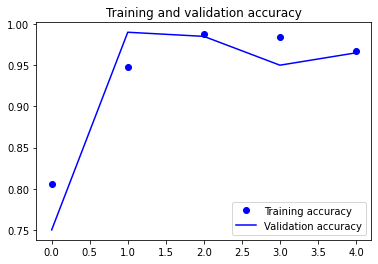

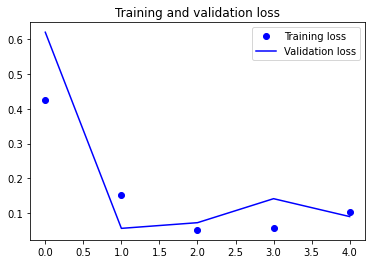

In [25]:
# Plot performance of the model over task=0
accuracy = mul_head_train.history['head_0_accuracy']
val_accuracy = mul_head_train.history['val_head_0_accuracy']
loss = mul_head_train.history['loss']
val_loss = mul_head_train.history['val_head_0_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Without EWC

In [26]:
# For all the tasks other than the task_0:
for task in range(1,num_tasks):
  
  print("\n\nWorking on task {}\n\n".format(task))

  mul_head.compile(loss={'head_{}'.format(task): cross_entropy},
                  optimizer='adam',
                  metrics={'head_{}'.format(task): "accuracy"})

  scale=2*task

  training_set_task=train_data[task*2].concatenate(train_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)
  validation_set_task=valid_data[task*2].concatenate(valid_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale)).prefetch(tf.data.AUTOTUNE)

  mul_head_train = mul_head.fit(training_set_task,
                                epochs=EPOCHS,
                                validation_data=validation_set_task)
  
heads_accuracy_no_EWC=[]
for task in range(num_tasks):
  heads_accuracy_no_EWC.append(check_test_acc(mul_head,task,test_data,normalize_pixels_scale_labels))

print()
print("Performances over test sets after the sequential training\nTask 0 --> Task 1 --> Task 2 --> Task 3 \nAre (no EWC):\n\n")
for task in range(num_tasks):
  print("Accuracy of the model over test set for task {} is:".format(task), np.round(heads_accuracy_no_EWC[task],4)),



Working on task 1


Epoch 1/5


28/28 [==============================] - 2s 62ms/step - loss: 0.2826 - head_1_loss: 0.2826 - head_1_accuracy: 0.8707 - val_loss: 0.3760 - val_head_1_loss: 0.3760 - val_head_1_accuracy: 0.8807
Epoch 2/5
28/28 [==============================] - 1s 38ms/step - loss: 0.3054 - head_1_loss: 0.3054 - head_1_accuracy: 0.8719 - val_loss: 0.2975 - val_head_1_loss: 0.2975 - val_head_1_accuracy: 0.8977
Epoch 3/5
28/28 [==============================] - 1s 43ms/step - loss: 0.2017 - head_1_loss: 0.2017 - head_1_accuracy: 0.9176 - val_loss: 0.2416 - val_head_1_loss: 0.2416 - val_head_1_accuracy: 0.8864
Epoch 4/5
28/28 [==============================] - 1s 38ms/step - loss: 0.2146 - head_1_loss: 0.2146 - head_1_accuracy: 0.9073 - val_loss: 0.2365 - val_head_1_loss: 0.2365 - val_head_1_accuracy: 0.8977
Epoch 5/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1691 - head_1_loss: 0.1691 - head_1_accuracy: 0.9245 - val_loss: 0.2935 - val_head_1_loss: 0.2935 - val_head_1_accuracy: 0.8807


28/28 [==============================] - 3s 69ms/step - loss: 0.2788 - head_2_loss: 0.2788 - head_2_accuracy: 0.9016 - val_loss: 0.2844 - val_head_2_loss: 0.2844 - val_head_2_accuracy: 0.8953
Epoch 2/5
28/28 [==============================] - 1s 43ms/step - loss: 0.1406 - head_2_loss: 0.1406 - head_2_accuracy: 0.9542 - val_loss: 0.2051 - val_head_2_loss: 0.2051 - val_head_2_accuracy: 0.9372
Epoch 3/5
28/28 [==============================] - 1s 44ms/step - loss: 0.1084 - head_2_loss: 0.1084 - head_2_accuracy: 0.9611 - val_loss: 0.1584 - val_head_2_loss: 0.1584 - val_head_2_accuracy: 0.9319
Epoch 4/5
28/28 [==============================] - 1s 44ms/step - loss: 0.0975 - head_2_loss: 0.0975 - head_2_accuracy: 0.9680 - val_loss: 0.1849 - val_head_2_loss: 0.1849 - val_head_2_accuracy: 0.9424
Epoch 5/5
28/28 [==============================] - 1s 44ms/step - loss: 0.0922 - head_2_loss: 0.0922 - head_2_accuracy: 0.9657 - val_loss: 0.1791 - val_head_2_loss: 0.1791 - val_head_2_accuracy: 0.9372


28/28 [==============================] - 2s 62ms/step - loss: 0.3281 - head_3_loss: 0.3281 - head_3_accuracy: 0.8666 - val_loss: 0.1379 - val_head_3_loss: 0.1379 - val_head_3_accuracy: 0.9454
Epoch 2/5
28/28 [==============================] - 1s 44ms/step - loss: 0.2401 - head_3_loss: 0.2401 - head_3_accuracy: 0.9111 - val_loss: 0.3071 - val_head_3_loss: 0.3071 - val_head_3_accuracy: 0.8689
Epoch 3/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1798 - head_3_loss: 0.1798 - head_3_accuracy: 0.9521 - val_loss: 0.1687 - val_head_3_loss: 0.1687 - val_head_3_accuracy: 0.9180
Epoch 4/5
28/28 [==============================] - 1s 38ms/step - loss: 0.1389 - head_3_loss: 0.1389 - head_3_accuracy: 0.9612 - val_loss: 0.2202 - val_head_3_loss: 0.2202 - val_head_3_accuracy: 0.9016
Epoch 5/5
28/28 [==============================] - 1s 43ms/step - loss: 0.1572 - head_3_loss: 0.1572 - head_3_accuracy: 0.9544 - val_loss: 0.1136 - val_head_3_loss: 0.1136 - val_head_3_accuracy: 0.9672


### With EWC

In [33]:
for task in range(1,num_tasks):
  
  print("\n\nWorking on task {}\n\n".format(task))

  mul_head.compile(loss={'head_{}'.format(task): EWC_loss(F,task_prev_param,Lambda=100)},
                  optimizer='adam',
                  metrics={'head_{}'.format(task): "accuracy"})

  scale=2*task

  training_set_task=train_data[task*2].concatenate(train_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale))
  validation_set_task=valid_data[task*2].concatenate(valid_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale))

  mul_head_train = mul_head.fit(training_set_task,
                                epochs=EPOCHS,
                                validation_data=validation_set_task)

  # Since the model parameters will be used by EWC regularization during the training over the next task copy them at the end of training.
  task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]

  # Compute the new Fisher matrixes and update it by summing old Fisher matrixes with the new ones
  new_F= compute_fisher_matrix(mul_head, validation_set_task, batch_size=250,task_id=task)
  for layer in range(len(F)):
    F[layer]=F[layer]+new_F[layer]

# Compute performances of the fully trained (with EWC)  model in each task
heads_accuracy_EWC=[]
for task in range(num_tasks):
  heads_accuracy_EWC.append(check_test_acc(mul_head,task,test_data,normalize_pixels_scale_labels))

print()
print("Performances over test sets after the sequential training\nTask 0 --> Task 1 --> Task 2 --> Task 3\nAre (with EWC):\n\n")
for task in range(num_tasks):
  print("Accuracy of the model over test set for task {} is:".format(task), np.round(heads_accuracy_EWC[task],4))



Working on task 1


Epoch 1/5
28/28 [==============================] - 3s 52ms/step - loss: 15.6104 - head_1_loss: 15.6104 - head_1_accuracy: 0.7975 - val_loss: 3.9998 - val_head_1_loss: 3.9998 - val_head_1_accuracy: 0.7955
Epoch 2/5
28/28 [==============================] - 1s 39ms/step - loss: 1.0165 - head_1_loss: 1.0165 - head_1_accuracy: 0.9096 - val_loss: 0.3376 - val_head_1_loss: 0.3376 - val_head_1_accuracy: 0.8864
Epoch 3/5
28/28 [==============================] - 1s 39ms/step - loss: 0.2569 - head_1_loss: 0.2569 - head_1_accuracy: 0.9268 - val_loss: 0.3041 - val_head_1_loss: 0.3041 - val_head_1_accuracy: 0.8977
Epoch 4/5
28/28 [==============================] - 2s 44ms/step - loss: 0.2181 - head_1_loss: 0.2181 - head_1_accuracy: 0.9245 - val_loss: 0.3184 - val_head_1_loss: 0.3184 - val_head_1_accuracy: 0.8864
Epoch 5/5
28/28 [==============================] - 1s 40ms/step - loss: 0.2110 - head_1_loss: 0.2110 - head_1_accuracy: 0.9222 - val_loss: 0.2956 - val_head_1_loss: 0.2



Working on task 1


28/28 [==============================] - 3s 57ms/step - loss: 12.7782 - head_1_loss: 12.7782 - head_1_accuracy: 0.8730 - val_loss: 0.4109 - val_head_1_loss: 0.4109 - val_head_1_accuracy: 0.8864


Working on task 2


28/28 [==============================] - 3s 58ms/step - loss: 12.5304 - head_2_loss: 12.5304 - head_2_accuracy: 0.8924 - val_loss: 0.3243 - val_head_2_loss: 0.3243 - val_head_2_accuracy: 0.9319


Working on task 3


28/28 [==============================] - 3s 58ms/step - loss: 14.8336 - head_3_loss: 14.8336 - head_3_accuracy: 0.7503 - val_loss: 0.6832 - val_head_3_loss: 0.6832 - val_head_3_accuracy: 0.8743


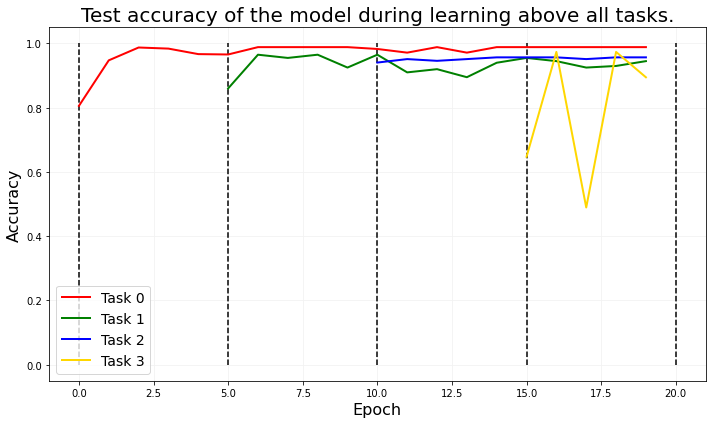

In [34]:
# Define list of lists to store the performance on test test of each head_0_1_2_3
accuracies=[[] for task in range(num_tasks)]

for task in range(1,num_tasks):
  
  print("\n\nWorking on task {}\n\n".format(task))

  scale=2*task

  for epoch in range(EPOCHS):

    mul_head.compile(loss={'head_{}'.format(task): EWC_loss(F,task_prev_param,Lambda=100)},
                    optimizer='adam',
                    metrics={'head_{}'.format(task): "accuracy"})

    training_set_task=train_data[task*2].concatenate(train_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale))
    validation_set_task=valid_data[task*2].concatenate(valid_data[task*2+1]).shuffle(1000).batch(BATCH_SIZE).map(lambda x,y: normalize_pixels_scale_labels(x,y, scale))

    mul_head_train = mul_head.fit(training_set_task,
                                  epochs=1,
                                  validation_data=validation_set_task)

    for intra_task in range(task+1):
      accuracies[intra_task].append(check_test_acc(mul_head,intra_task,test_data,normalize_pixels_scale_labels))

  task_prev_param=[tf.identity(mul_head.trainable_variables[layer]) for layer in range(len(mul_head.trainable_variables))]

  new_F= compute_fisher_matrix(mul_head, validation_set_task, batch_size=256,task_id=task)
  for layer in range(len(F)):
    F[layer]=F[layer]+new_F[layer]

# Append learning accuracy trend obtained during learning on task 0
accuracies[0]=accuracy+accuracies[0]

# Perform the plot
training_phases=np.array(range(0,EPOCHS*EPOCHS,EPOCHS))
colors=["red","green","blue", "gold"]
plt.figure(figsize=(10,6), tight_layout=True)
for task in range(num_tasks):
  plt.plot(range(EPOCHS*task,len(accuracies[task])+EPOCHS*task), accuracies[task], color=colors[task],linewidth=2, label='Task {}'.format(task))
plt.vlines(training_phases,0,1,linestyles="dashed")
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title(('Test accuracy of the model during learning above all tasks.'),fontsize=20)
plt.legend(fontsize=14,loc="lower left")
plt.grid(axis='x', color='0.95')
plt.grid(axis='y', color='0.95')
plt.savefig('intertask_accuracies.png')
plt.show()